In [1]:
# download dataset to file

import kagglehub
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [2]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torchinfo import summary
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from transformers.models.mobilenet_v2 import MobileNetV2Model
from transformers.models.mobilenet_v2 import MobileNetV2PreTrainedModel
from transformers.models.mobilenet_v2.configuration_mobilenet_v2 import MobileNetV2Config

2025-06-03 14:09:01.356074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748959741.577358      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748959741.643973      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# constants
DEBUG = True
PRETRAINED_CONFIG = ''
# https://huggingface.co/google/mobilenet_v2_1.4_224
PRETRAINED_MODEL = 'google/mobilenet_v2_1.4_224'
#cfg = MobileNetV2Config(PRETRAINED_CONFIG)
cfg = MobileNetV2Config()
BATCH_SIZE = 32
NUM_EPOCHS = 50

if not torch.cuda.is_available():
    print('GPU not available, running script on CPU..')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class FERDataset(torch.utils.data.Dataset):
    # https://www.kaggle.com/datasets/msambare/fer2013
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = self._transform
        self.target_transform = self._target_transform
        self.class_map_loaded = {
            'angry': 0,
            'disgust': 1,
            'fear': 2,
            'happy': 3,
            'neutral': 4,
            'sad': 5,
            'surprise': 6
        }
        self.class_map_minimized = {
            'angry': 1,
            'disgust': 1,
            'fear': 1,
            'happy': 0,
            'neutral': 2,
            'sad': 1,
            'surprise': 0
        }
        self.class_map = {
            0: 'positive',
            1: 'negative',
            2: 'neutral'
        }
        self.NUM_CLASSES = len(self.class_map)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        label = self.labels[idx]
        label = self.target_transform(label)

        return image, label

    def _transform(self, image):
        image = cv2.imread(image)
        image = Image.fromarray(image)
        image = transforms.functional.pil_to_tensor(image)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225])
        image = normalize(image/255.0)

        return image

    def _target_transform(self, target):
        # TODO: map to new class map
        target = self.class_map_minimized[target]
        return int(target)

In [5]:
# load dataset into script
print('loading dataset from file...')

train_images = []
train_labels = []
for subdir in os.listdir(path+'/train'):
    for idx in os.listdir(path+'/train/'+subdir):
        train_images.append(path+'/train/'+subdir+'/'+idx)
        train_labels.append(subdir)
        #if DEBUG:
        #    print(path+'/train/'+subdir+'/'+idx)
        #   print(subdir)

test_images = []
test_labels = []
for subdir in os.listdir(path+'/test'):
    for idx in os.listdir(path+'/test/'+subdir):
        test_images.append(path+'/test/'+subdir+'/'+idx)
        test_labels.append(subdir)
print('...done')

loading dataset from file...
...done


In [6]:
# create dataloaders
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

if DEBUG:
    for i in range(0, 10):
        print(x_val[i], '|', y_val[i])

train_dataset = FERDataset(x_train, y_train)
val_dataset = FERDataset(x_val, y_val)
test_dataset = FERDataset(test_images, test_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/kaggle/input/fer2013/train/surprise/Training_76383893.jpg | surprise
/kaggle/input/fer2013/train/fear/Training_2632898.jpg | fear
/kaggle/input/fer2013/train/fear/Training_44816489.jpg | fear
/kaggle/input/fer2013/train/neutral/Training_31924948.jpg | neutral
/kaggle/input/fer2013/train/sad/Training_46482890.jpg | sad
/kaggle/input/fer2013/train/angry/Training_94445414.jpg | angry
/kaggle/input/fer2013/train/neutral/Training_33797762.jpg | neutral
/kaggle/input/fer2013/train/happy/Training_42525079.jpg | happy
/kaggle/input/fer2013/train/happy/Training_97644398.jpg | happy
/kaggle/input/fer2013/train/happy/Training_83256151.jpg | happy


In [7]:
if DEBUG:
    for i, (image, label) in enumerate(test_dataloader):
        for j in range(BATCH_SIZE):
            pass
            #print('Label:', label[j])
            #plt.imshow(image[j].permute(1, 2, 0))
            #plt.show()
        break

In [8]:
class MobileNetV2ForFacialExpressionRecognition(MobileNetV2PreTrainedModel):
    """
    from MobileNetV2 for image classification
    """
    def __init__(self, config):
        super().__init__(config=config)

        self.num_labels = 3
        self.mobilenet_v2 = MobileNetV2Model(config)

        last_hidden_size = self.mobilenet_v2.conv_1x1.convolution.out_channels

        # Classifier head
        self.dropout = torch.nn.Dropout(config.classifier_dropout_prob, inplace=True)
        self.classifier = torch.nn.Linear(last_hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(self, pixel_values=None, output_hidden_states=None, labels=None):
        outputs = self.mobilenet_v2(pixel_values, output_hidden_states=output_hidden_states)
        pooled_output = outputs[1]
        logits = self.classifier(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            self.config.problem_type = "multi_label_classification"
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        output = (logits,) + outputs[2:]
        return ((loss,) + output) if loss is not None else output

In [9]:
print('...creating MobileNetV2 model')
model = MobileNetV2ForFacialExpressionRecognition(cfg).from_pretrained(PRETRAINED_MODEL)
model.to(DEVICE)
summary(model, input_size=(BATCH_SIZE, 3, 48, 48))

...creating MobileNetV2 model


config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2ForFacialExpressionRecognition          [32, 1001]                --
├─MobileNetV2Model: 1-1                            [32, 1792]                --
│    └─MobileNetV2Stem: 2-1                        [32, 24, 24, 24]          --
│    │    └─MobileNetV2ConvLayer: 3-1              [32, 48, 24, 24]          1,392
│    │    └─MobileNetV2ConvLayer: 3-2              [32, 48, 24, 24]          528
│    │    └─MobileNetV2ConvLayer: 3-3              [32, 24, 24, 24]          1,200
│    └─ModuleList: 2-2                             --                        --
│    │    └─MobileNetV2InvertedResidual: 3-4       [32, 32, 12, 12]          10,000
│    │    └─MobileNetV2InvertedResidual: 3-5       [32, 32, 12, 12]          14,848
│    │    └─MobileNetV2InvertedResidual: 3-6       [32, 48, 6, 6]            17,952
│    │    └─MobileNetV2InvertedResidual: 3-7       [32, 48, 6, 6]            31,488
│    │    └─

In [10]:
# loss function & optimizer
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [11]:
# compute accuracy
def compute_accuracy(outputs, targets):
    predictions = torch.argmax(outputs, 1)
    num_predictions = len(predictions)

    predictions = predictions.cpu()
    targets = targets.cpu()
    num_incorrect = 0
    for i in range(len(predictions)):
        if not predictions[i] == targets[i]:
            num_incorrect = num_incorrect + 1
    accuracy = (num_predictions-num_incorrect)/num_predictions

    return accuracy

In [12]:
# train function
def train(model, dataloader, device, epoch, num_epochs, total_steps):
    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        targets = labels.to(device)

        outputs = model(images)
        outputs = outputs[0]

        loss = loss_fn(outputs, targets)
        accuracy = compute_accuracy(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy

        if (i+1) % 50 == 0:
            print(
                f'TRAINING --> Epoch: {epoch+1}/{num_epochs}, ' +
                f'Step: {i+1}/{total_steps}, ' +
                f'Loss: {running_loss / (i+1)}, '
                f'Accuracy: {running_acc / (i+1)}'
            )
    
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [13]:
# validate function
def validate(model, dataloader, device, epoch, num_epochs, total_steps):
    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            targets = labels.to(device)
    
            outputs = model(images)
            outputs = outputs[0]
    
            loss = loss_fn(outputs, targets)
            accuracy = compute_accuracy(outputs, targets)
    
            running_loss += loss.item()
            running_acc += accuracy
    
            if (i+1) % 50 == 0:
                print(
                    f'VALIDATION --> Epoch: {epoch+1}/{num_epochs}, ' +
                    f'Step: {i+1}/{total_steps}, ' +
                    f'Loss: {running_loss / (i+1)}, '
                    f'Accuracy: {running_acc / (i+1)}'
                )
    
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [14]:
def save_best_model(
    model: torch.nn.Module,
    model_save_path,
    val_loss: float,
    val_losses: list,
    epoch: int,
    keep_models: bool = False
):
    """Save the model if it is the first epoch. Subsequently, save the model
    only if a lower validation loss is achieved whilst training.

    :param model: The model to save.
    :type model: torch.nn.Module
    :param model_save_path: The location to save the model to.
    :type model_save_path: Path
    :param val_loss: The current epoch's validation loss.
    :type val_loss: float
    :param val_losses: The history of all other validation losses.
    :type val_losses: list
    :param epoch: The current epoch number.
    :type epoch: int
    :param keep_models: Should all models be saved, defaults to False
    :type keep_models: bool, optional
    """
    # Should we keep all models or just one
    if keep_models:
        model_save_path = model_save_path / f'model_{epoch+1}_{val_loss}.pt'
    else:
        model_save_path = model_save_path / f'model_state_dict.pt'
    # Save the first model
    if len(val_losses) == 0:
        torch.save(
            model.state_dict(),
            model_save_path
        )
        print(
            'SAVING --> First epoch: \n' +
            f'Val Loss: {val_loss}\n' +
            f'Saving new model to:\n{model_save_path}'
        )
    elif val_loss < min(val_losses):
        # If our new validation loss is less than the previous best save the
        # model
        print(
            'SAVING --> Found model with better validation loss: \n' +
            f'New Best Val Loss: {val_loss}\n' +
            f'Old Best Val Loss: {min(val_losses)}\n'
            f'Saving new model to:\n{model_save_path}'
        )
        torch.save(
            model.state_dict(),
            model_save_path
        )

In [15]:
def plot_epoch_metrics(x, y, data_names, title_prefix, yaxis_label):
    """Plot metrics with the number of epochs on the x axis and the metric of
    interest on the y axis. Note that this function differs based on the input.

    :param x: The values to use on the x-axis.
    :type x: list
    :param y: A list of lists containing len(x) data points to plot. The inner
        lists are the different series to plot.
    :type y: list
    :param data_names: Names of the series to use in the legend.
    :type data_names: str
    :param title_prefix: A prefix to add before everything else in the title.
    :type title_prefix: str
    :param yaxis_label: The label for the y axis.
    :type yaxis_label: str
    """
    # Plot multiple series of data
    for i in y:
        plt.plot(x, i)
    # Set the title
    plt.title(title_prefix + ' ' + ' vs. '.join(data_names) + ' ' + yaxis_label)
    # Set the y axis label
    plt.ylabel(yaxis_label)
    # Enable the legend with the appropriate names
    plt.legend(data_names)

In [16]:
# train_loop
def train_loop(model, train_dataloader, val_dataloader, device, num_epochs, model_save_path=Path('./models')):
    print(f'Models will be saved to: {model_save_path}')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    if not model_save_path.exists():
        model_save_path.mkdir(exist_ok=True, parents=True)

    train_total_steps = len(train_dataloader)
    val_total_steps = len(val_dataloader)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, device, epoch, num_epochs, train_total_steps)
        print(
            f'TRAINING --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {train_loss}, Avg Accuracy: {train_accuracy}'
        )

        val_loss, val_accuracy = validate(model, val_dataloader, device, epoch, num_epochs, val_total_steps)
        print(
            f'VALIDATION --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {val_loss}, Avg Accuracy: {val_accuracy}'
        )

        save_best_model(model, model_save_path, val_loss, val_losses, epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
    return (train_losses, train_accs), (val_losses, val_accs)

In [17]:
# run training
print('training..')
(train_losses, train_accs), (val_losses, val_accs) = train_loop(model, train_dataloader, val_dataloader, DEVICE, NUM_EPOCHS)
print(f'Best Validation Loss: {min(val_losses)} after epoch {np.argmin(val_losses) + 1}')
print(f'Best Validation Acc: {max(val_accs)} after epoch {np.argmax(val_accs) + 1}')

training..
Models will be saved to: models
TRAINING --> Epoch: 1/50, Step: 50/718, Loss: 3.5415181422233584, Accuracy: 0.33125
TRAINING --> Epoch: 1/50, Step: 100/718, Loss: 2.4048886734247206, Accuracy: 0.4
TRAINING --> Epoch: 1/50, Step: 150/718, Loss: 1.977228118578593, Accuracy: 0.43
TRAINING --> Epoch: 1/50, Step: 200/718, Loss: 1.7626200568675996, Accuracy: 0.441875
TRAINING --> Epoch: 1/50, Step: 250/718, Loss: 1.6244445965290069, Accuracy: 0.456875
TRAINING --> Epoch: 1/50, Step: 300/718, Loss: 1.535479744275411, Accuracy: 0.461875
TRAINING --> Epoch: 1/50, Step: 350/718, Loss: 1.4590028747490473, Accuracy: 0.47330357142857143
TRAINING --> Epoch: 1/50, Step: 400/718, Loss: 1.4068092954158784, Accuracy: 0.479140625
TRAINING --> Epoch: 1/50, Step: 450/718, Loss: 1.36174113339848, Accuracy: 0.48465277777777777
TRAINING --> Epoch: 1/50, Step: 500/718, Loss: 1.324593141913414, Accuracy: 0.4909375
TRAINING --> Epoch: 1/50, Step: 550/718, Loss: 1.29362377632748, Accuracy: 0.4951704545

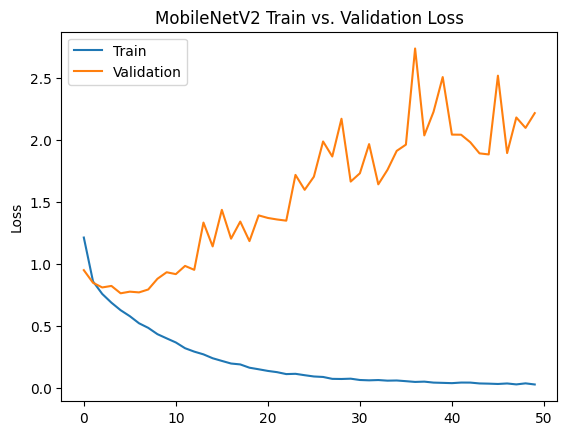

In [18]:
# TODO: plot train vs validation loss
plot_epoch_metrics(
    np.arange(NUM_EPOCHS),
    [train_losses, val_losses],
    ['Train', 'Validation'],
    'MobileNetV2',
    'Loss'
)

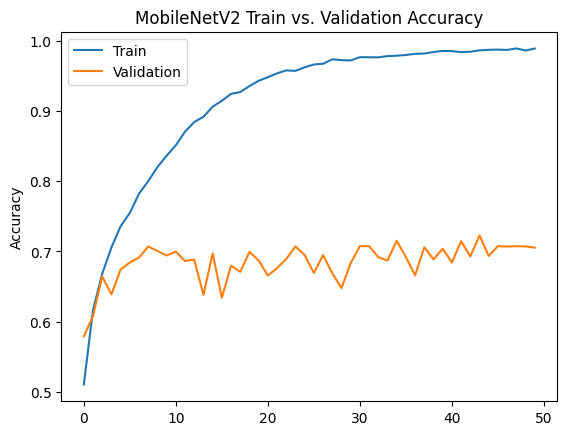

In [19]:
# TODO: plot train vs validation accuracy
plot_epoch_metrics(
    np.arange(NUM_EPOCHS),
    [train_accs, val_accs],
    ['Train', 'Validation'],
    'MobileNetV2',
    'Accuracy'
)

In [20]:
# evaluate function (test data)
def evaluate(model, dataloader, device, total_steps):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            targets = labels.to(device)
    
            outputs = model(images)
            outputs = outputs[0]

            loss = loss_fn(outputs, targets)
            accuracy = compute_accuracy(outputs, targets)
    
            running_loss += loss.item()
            running_acc += accuracy
    
            if (i+1) % 256 == 0:
                print(
                    f'TEST' +
                    f'Step: {i+1}/{total_steps}, ' +
                    f'Loss: {running_loss / (i+1)}, '
                    f'Accuracy: {running_acc / (i+1)}'
                )
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [21]:
# run evaluation (test)
test_loss, test_accuracy = evaluate(model, test_dataloader, DEVICE, len(test_dataloader))
print(
    f'TEST --> DONE, ' +
    f'Avg Loss: {test_loss}, Avg Accuracy: {test_accuracy}'
)

TEST --> DONE, Avg Loss: 2.0713570507367454, Avg Accuracy: 0.7252500000000001


In [22]:
# TODO: export to ONNX